In [1]:
%matplotlib inline

In [2]:
import nilearn
from nilearn.input_data import NiftiLabelsMasker
help(NiftiLabelsMasker)

Help on class NiftiLabelsMasker in module nilearn.input_data.nifti_labels_masker:

class NiftiLabelsMasker(nilearn.input_data.base_masker.BaseMasker, nilearn._utils.cache_mixin.CacheMixin)
 |  NiftiLabelsMasker(labels_img, labels=None, background_label=0, mask_img=None, smoothing_fwhm=None, standardize=False, standardize_confounds=True, high_variance_confounds=False, detrend=False, low_pass=None, high_pass=None, t_r=None, dtype=None, resampling_target='data', memory=Memory(location=None), memory_level=1, verbose=0, strategy='mean', reports=True)
 |  
 |  Class for masking of Niimg-like objects.
 |  
 |  NiftiLabelsMasker is useful when data from non-overlapping volumes should
 |  be extracted (contrarily to NiftiMapsMasker). Use case: Summarize brain
 |  signals from clusters that were obtained by prior K-means or Ward
 |  clustering.
 |  
 |  Parameters
 |  ----------
 |  labels_img : Niimg-like object
 |      See http://nilearn.github.io/manipulating_images/input_output.html
 |      


# Decoding of a dataset after GLM fit for signal extraction

Full step-by-step example of fitting a GLM to perform a decoding experiment.
We use the data from one subject of the Haxby dataset.

More specifically:

1. Download the Haxby dataset.
2. Extract the information to generate a glm representing the blocks of stimuli.
3. Analyze the decoding performance using a classifier.

To run this example, you must launch IPython via ``ipython
--matplotlib`` in a terminal, or use the Jupyter notebook.
    :depth: 1


## Fetch example Haxby dataset
We download the Haxby dataset
This is a study of visual object category representation



In [3]:
# By default 2nd subject will be fetched
import nibabel as nib
import nilearn
import seaborn as sns
import pandas as pd
from pathlib import Path
from pandas import DataFrame as df
import numpy as np
import pandas as pd
from nilearn import datasets
import sklearn
from sklearn.utils import Bunch as bunch
from tqdm import tqdm
from os.path import expanduser as xpu
import loadutils as lu
haxby_dataset = datasets.fetch_haxby(data_dir=xpu('~/../../data/cisl/DATA/nilearn_data/haxy'),
                                     subjects=list(range(1,6)),
                                     fetch_stimuli=True,
                                     resume=True,
                                     verbose=1)

# repetition has to be known
TR = 2.5

/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


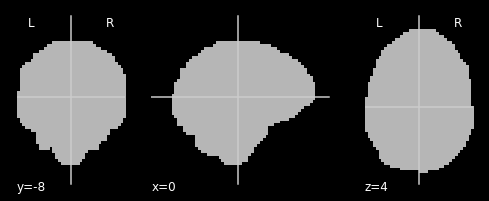

In [11]:
from nilearn.plotting import plot_epi, plot_img, plot_anat
plot_anat(haxby_dataset.mask)

In [90]:
# from pathlib import Path
# haxby_description=Path(haxby_dataset.description).read_text().decode()
# haxby_description
# from io import StringIO
# pd.read_csv(StringIO())
# haxby_dataset.description.decode().splitlines()

## Load the behavioral data



In [91]:
# Load target information as string and give a numerical identifier to each
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=' ')
conditions = behavioral['labels'].values

# Record these as an array of sessions
sessions = behavioral['chunks'].values
unique_sessions = behavioral['chunks'].unique()

# fMRI data: a unique file for each session
func_filename = haxby_dataset.func[0]

In [92]:
# conditions,conditions.shape,sessions,sessions.shape
behavioral

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


In [93]:
import nibabel as nib
# nib.load(func_filename).shape,
unique_sessions
# behavioral.shape
# nib.load(subject_data.mar_scans.func[1][0]).shape

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [94]:
# behavioral.labels.unique()
unique_sessions
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=' ')
behavioral.labels.unique().__len__(),behavioral.chunks.unique().__len__()

(9, 12)

## Build a proper event structure for each session



In [95]:
def get_events(behavioral,
               TR:float=2.5) -> dict:
    conditions = behavioral['labels'].values

    # Record these as an array of sessions
    sessions = behavioral['chunks'].values
    unique_sessions = behavioral['chunks'].unique()

    # fMRI data: a unique file for each session
    func_filename = haxby_dataset.func[0]
    events = {}
    # events will take  the form of a dictionary of Dataframes, one per session
    for session in unique_sessions:
        # get the condition label per session
        conditions_session = conditions[sessions == session]
        # get the number of scans per session, then the corresponding
        # vector of frame times
        n_scans = len(conditions_session)
        frame_times = TR * np.arange(n_scans)
        # each event last the full TR
        duration = TR * np.ones(n_scans)
        # Define the events object
        events_ = pd.DataFrame(
            {'onset': frame_times,
             'trial_type': conditions_session,
             'duration': duration})
        # remove the rest condition and insert into the dictionary
        events[session] = events_[events_.trial_type != 'rest']
    return events,sessions,unique_sessions
events,sessions,unique_sessions=get_events(behavioral)
events

{0:      onset trial_type  duration
 6     15.0   scissors       2.5
 7     17.5   scissors       2.5
 8     20.0   scissors       2.5
 9     22.5   scissors       2.5
 10    25.0   scissors       2.5
 ..     ...        ...       ...
 110  275.0      chair       2.5
 111  277.5      chair       2.5
 112  280.0      chair       2.5
 113  282.5      chair       2.5
 114  285.0      chair       2.5
 
 [72 rows x 3 columns],
 1:      onset    trial_type  duration
 6     15.0          face       2.5
 7     17.5          face       2.5
 8     20.0          face       2.5
 9     22.5          face       2.5
 10    25.0          face       2.5
 ..     ...           ...       ...
 110  275.0  scrambledpix       2.5
 111  277.5  scrambledpix       2.5
 112  280.0  scrambledpix       2.5
 113  282.5  scrambledpix       2.5
 114  285.0  scrambledpix       2.5
 
 [72 rows x 3 columns],
 2:      onset trial_type  duration
 6     15.0        cat       2.5
 7     17.5        cat       2.5
 8     20.0 

In [96]:
len(events)

12

## Instantiate and run FirstLevelModel

We generate a list of z-maps together with their session and condition index



In [97]:
# Instantiate the glm
from nilearn.glm.first_level import FirstLevelModel
glm = FirstLevelModel(t_r=TR,
                      mask_img=haxby_dataset.mask,
                      high_pass=.008,
                      smoothing_fwhm=4,
                      memory='nilearn_cache')

## Run the glm on data from each session



In [ ]:
from nilearn.image import index_img
def sessions_glm(events,sessions,unique_sessions):
    z_maps = []
    conditions_label = []
    session_label = []
    for session in tqdm(unique_sessions):
        # grab the fmri data for that particular session
        fmri_session = index_img(func_filename, sessions == session)

        # fit the glm
        glm.fit(fmri_session, events=events[session])

        # set up contrasts: one per condition
        conditions = events[session].trial_type.unique()
        for condition_ in conditions:
            z_maps.append(glm.compute_contrast(condition_))
            conditions_label.append(condition_)
            session_label.append(session)
    return z_maps,conditions_label,session_label
z_maps,conditions_label,session_label=sessions_glm(events,sessions,unique_sessions)


  0%|                                                    | 0/12 [00:00<?, ?it/s]

## Generating a report
Since we have already computed the FirstLevelModel
and have the contrast, we can quickly create a summary report.



In [ ]:
from nilearn.image import mean_img
from nilearn.reporting import make_glm_report
mean_img_ = mean_img(func_filename)
report = make_glm_report(glm,
                         contrasts=conditions,
                         bg_img=mean_img_,
                         )

report  # This report can be viewed in a notebook

In a jupyter notebook, the report will be automatically inserted, as above.
We have several other ways to access the report:



In [ ]:
# report.save_as_html('report.html')
# report.open_in_browser()

## Build the decoding pipeline
To define the decoding pipeline we use Decoder object, we choose :

    * a prediction model, here a Support Vector Classifier, with a linear
      kernel

    * the mask to use, here a ventral temporal ROI in the visual cortex

    * although it usually helps to decode better, z-maps time series don't
      need to be rescaled to a 0 mean, variance of 1 so we use
      standardize=False.

    * we use univariate feature selection to reduce the dimension of the
      problem keeping only 5% of voxels which are most informative.

    * a cross-validation scheme, here we use LeaveOneGroupOut
      cross-validation on the sessions which corresponds to a
      leave-one-session-out

We fit directly this pipeline on the Niimgs outputs of the GLM, with
corresponding conditions labels and session labels (for the cross validation).



In [ ]:
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut
decoder = Decoder(estimator='svc', mask=haxby_dataset.mask, standardize=False,
                  screening_percentile=5, cv=LeaveOneGroupOut())
decoder.fit(z_maps, conditions_label, groups=session_label)

# Return the corresponding mean prediction accuracy compared to chance

classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
chance_level = 1. / len(np.unique(conditions))
print('Classification accuracy: {:.4f} / Chance level: {}'.format(
    classification_accuracy, chance_level))